In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import glob
import json
from xgboost import XGBRegressor
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from utils import score, visualize_result, storeData, readData, create_sequences, setSeed

2023 Refernece Data

In [2]:
ref_data = pd.read_csv('data/reference.csv', index_col = [0])
ref_data.index = pd.to_datetime(ref_data.index)
ref_data

,REF-O3,REF-CO,REF-NO2,REF-SO2,REF-PM2.5,REF-PM10,REF-RH,REF-AMB_TEMP
2023-01-01 00:00:00,38.7,0.23,4.8,1.0,14.0,14.0,86.0,18.4
2023-01-01 01:00:00,38.3,0.22,5.3,0.4,9.0,13.0,87.0,18.6
2023-01-01 02:00:00,38.3,0.22,4.4,0.2,6.0,8.0,89.0,18.5
2023-01-01 03:00:00,38.3,0.21,4.1,0.1,8.0,3.0,88.0,18.6
2023-01-01 04:00:00,38.2,0.20,3.9,0.5,5.0,4.0,88.0,18.9
...,...,...,...,...,...,...,...,...
2023-04-24 06:00:00,24.1,0.32,11.5,0.5,26.0,55.0,94.0,22.1
2023-04-24 07:00:00,42.3,0.28,11.0,0.5,28.0,61.0,95.0,22.1
2023-04-24 08:00:00,36.8,0.38,13.1,0.3,28.0,69.0,94.0,22.3
2023-04-24 09:00:00,34.0,0.33,15.0,0.8,26.0,62.0,95.0,22.2


SGX Raw Data

In [3]:
sgx_data = pd.read_csv('data/sgx.csv', index_col = [0])
sgx_data.index = pd.to_datetime(sgx_data.index)
sgx_data

,SGX-O3,SGX-CO,SGX-NO2,SGX-SO2
measure_time,,,,
2023-01-01 08:00:00,-1.539167,6.763333,28.492500,115.645333
2023-01-01 09:00:00,-0.052000,5.354000,35.532833,143.715667
2023-01-01 10:00:00,-0.260333,5.516667,41.556333,168.006500
2023-01-01 11:00:00,-0.130000,5.578000,44.988500,184.928333
2023-01-01 12:00:00,-0.469000,6.089000,45.418000,196.317667
...,...,...,...,...
2023-04-24 03:00:00,-0.403833,8.607667,19.882167,77.999000
2023-04-24 04:00:00,0.000000,6.879167,29.936500,78.948333
2023-04-24 05:00:00,-0.052000,7.107167,29.345833,78.634667


Target Gas

In [4]:
target_gas = 'CO'
additional_feature = []
all_feature = ['SGX-' + target_gas] + additional_feature
all_feature

['SGX-CO']

Data Division (Train, Validation, Test)

In [6]:
dates = sgx_data.loc[sgx_data.index.isin(ref_data.index), :].index
train, test = np.split(dates, [int(.85*len(dates))])
print('Train size: {:d}, Test size: {:d}'.format(len(train), len(test)))

Train size: 1846, Test size: 326


In [7]:
x_train = pd.concat([sgx_data.loc[train, all_feature], ref_data.loc[train, ['REF-RH', 'REF-AMB_TEMP']]], axis=1)
x_test = pd.concat([sgx_data.loc[test, all_feature], ref_data.loc[test, ['REF-RH', 'REF-AMB_TEMP']]], axis=1)

y_train = ref_data.loc[train, [f'REF-{target_gas}']]
y_test = ref_data.loc[test, [f'REF-{target_gas}']]

Standardization

In [8]:
scaler = MinMaxScaler()

scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

print('X-Train size: {}, X-Test size: {}'.format(x_train.shape, x_test.shape))
print('Y-Train size: {}, Y-Test size: {}'.format(y_train.shape, y_test.shape))

X-Train size: (1846, 3), X-Test size: (326, 3)
Y-Train size: (1846, 1), Y-Test size: (326, 1)


Model Selection

In [14]:
#################################################
# model_type = 'SVR'
# svr = SVR()
# param = {'kernel' : ('linear', 'poly', 'rbf'),
#          'C' : [0.1, 1, 5],
#          'degree' : [2, 3, 5],
#          'coef0' : [0.01, 0.5, 1],
#          'gamma' : ('auto','scale')},
#################################################
# model_type = 'RF'
# rf = RandomForestRegressor()
# param = {
#     'n_estimators': [100, 300, 500, 700],
#     'max_depth': [1, 4, 8, 10],
#     'bootstrap': [True, False],
#     'min_samples_split': [2, 8, 16, 20]
#     }
#################################################
# model_type = 'xgb'
# xgb = XGBRegressor()
# param = {  'max_depth': [2, 3, 6, 10],
#            'learning_rate': [0.001, 0.01, 0.05, 0.1],
#            'n_estimators': [100, 500, 1000],
#            'colsample_bytree': [0.3, 0.5, 0.7]}
#################################################
# model_type = 'mlp'
# regr = MLPRegressor()
# param = {  'hidden_layer_sizes': [[64], [128], [128, 128], [64, 128, 64]],
#            'alpha': [1e-5, 1e-4, 1e-3],
#            'learning_rate_init' : [1e-5, 1e-4, 1e-3],
#            'solver' : ['adam'],
#            'shuffle': [False],
#            'early_stopping': [True],
#            'random_state': [0]}
################################################
model_type = 'lr'
model = LinearRegression().fit(x_train,y_train.ravel())

# grid_search = GridSearchCV(estimator = svr, param_grid = param, cv = 5, n_jobs = -1, verbose = 2)
# grid_search.fit(x_train,y_train.ravel())

In [10]:
grid_search.best_params_

{'C': 5, 'coef0': 0.01, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}

In [11]:
model = grid_search.best_estimator_

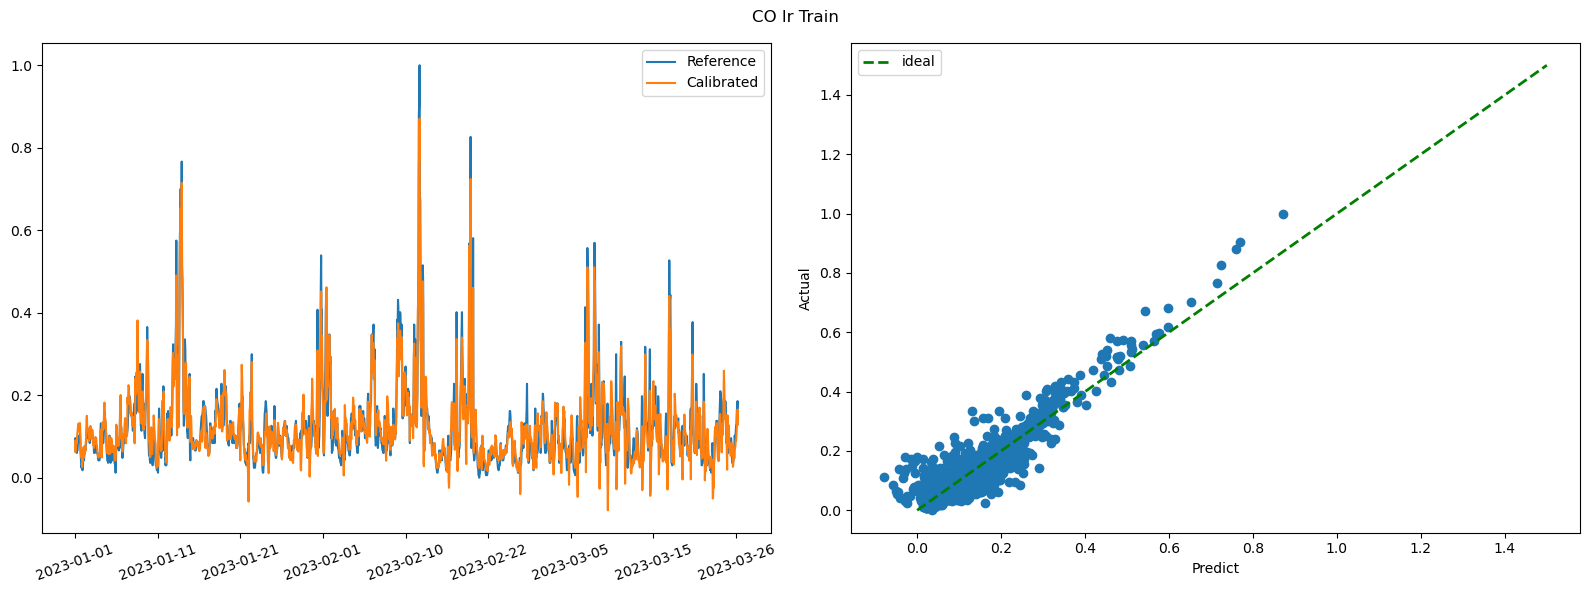

***R2 Score: 0.81
***RMSE: 0.0394


In [15]:
y_pred = model.predict(x_train)
visualize_result(y_train.ravel(), y_pred, train, f'{target_gas} {model_type} Train')
score(y_pred, y_train)

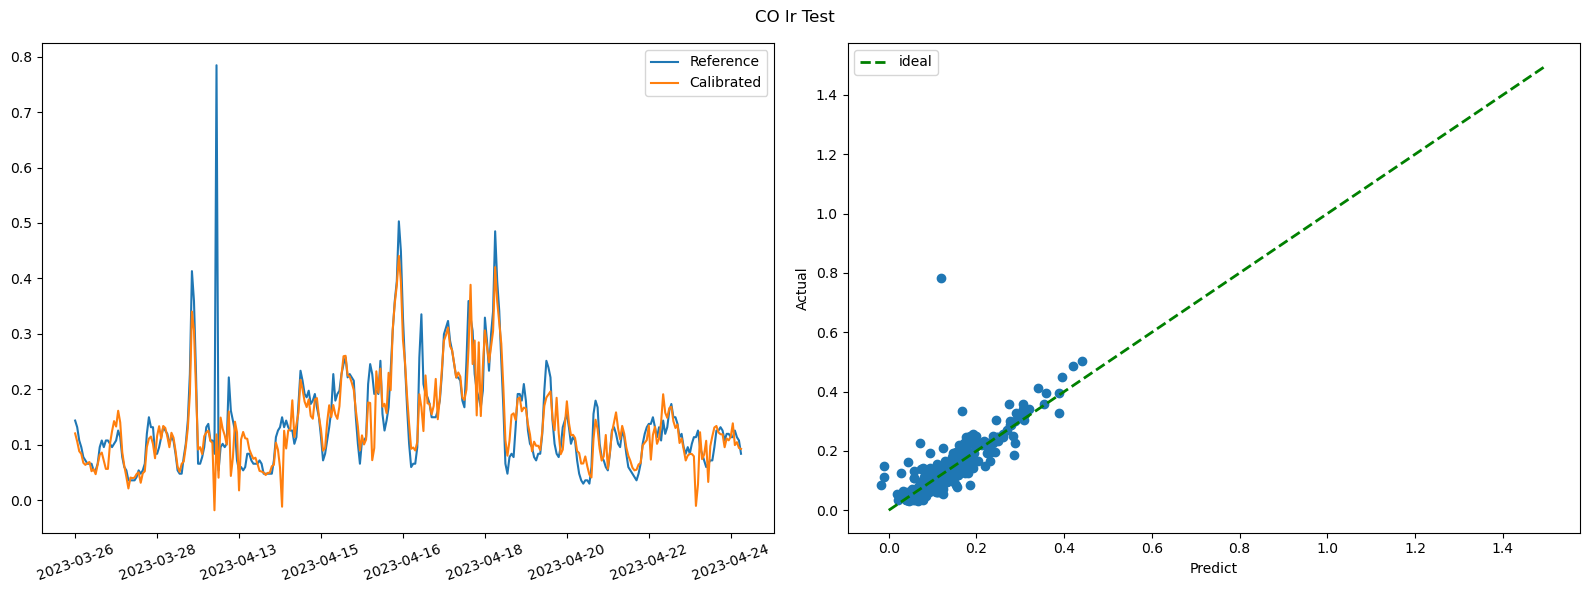

***R2 Score: 0.54
***RMSE: 0.0511


In [16]:
y_pred = model.predict(x_test)
visualize_result(y_test.ravel(), y_pred, test, f'{target_gas} {model_type} Test')
score(y_pred, y_test)

In [27]:
regr = LinearRegression()
regr.fit(sgx_data['SGX-NO2'].values.reshape(-1, 1), sgx_data['SGX-SO2'].values.reshape(-1, 1))
print(regr.coef_, regr.intercept_)
m = round(regr.coef_[0][0], 2)
b = round(regr.intercept_[0], 2)

[[4.16429998]] [19.06678441]
